In [23]:
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

from typing import List, Dict
from gretel_client import configure_session

In [24]:
# Specify your Gretel API key

pd.set_option("max_colwidth", None)

configure_session(api_key='grtu9cd34f3901cfac9e13f08002d42705fcbb214dca7a7731179c6a318cb2af2e0a', cache="yes", validate=True)


Using endpoint https://api.gretel.cloud
Logged in as hoang.nd@orai.io ✅


In [25]:
# Load timeseries example to a dataframe

data_source = "./AAPL Historical Data.csv"
original_df = pd.read_csv(data_source)
original_df.to_csv("original.csv", index=False)
original_df


,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17
...,...,...
94,09/01/2021,141.50
95,10/01/2021,149.80
96,11/01/2021,165.30
97,12/01/2021,177.57


In [26]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - Price
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - Date
              
"""


In [27]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client.projects import create_or_get_unique_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_or_get_unique_project(name="numbershift-transform")

model = project.create_model_obj(
    model_config=yaml.safe_load(config), data_source=data_source
)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")


INFO: Starting poller


{
    "uid": "6343849833192db2cd7b72af",
    "guid": "model_2FvOlNfRpNKCJl57yfkSLHLf7Rw",
    "model_name": "cheerful-humorous-snake",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633ffe8e44a4f15b630a3527",
    "project_guid": "proj_2FnqhzkG3XtUbB0nSxJQHK6Y0fU",
    "status_history": {
        "created": "2022-10-10T02:34:00.751579Z"
    },
    "last_modified": "2022-10-10T02:34:00.965675Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:c9b59a72bc0f0d73111d7bc7e52a9c5b8cb6eb44734caa23dc02b1672fa7fc51",
    "container_image_version": "2.10.0",
    "model_type": "transform",
    "config": {
        "schema_ver

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-10-10T02:34:20.976716Z  Starting transforms model training
2022-10-10T02:34:20.977445Z  Loading training data
2022-10-10T02:34:21.833654Z  Using up to 10000 records for training
2022-10-10T02:34:21.834055Z  Training data loaded
2022-10-10T02:34:21.834453Z  Beginning transforms model training
2022-10-10T02:34:24.941192Z  Saving model archive
2022-10-10T02:34:24.943018Z  Saving training report
2022-10-10T02:34:24.944289Z  Generating data preview with up to 100 records
2022-10-10T02:34:24.971299Z  Done generating data preview
2022-10-10T02:34:24.971887Z  Uploading artifacts to Gretel Cloud
2022-10-10T02:34:26.174211Z  Model creation complete!
INFO: Starting poller


{
    "uid": "634384b837a4879abc0321df",
    "guid": "model_run_2FvOpPAUeJ9LXv0qiydsLo3ZgKP",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633ffe8e44a4f15b630a3527",
    "project_guid": "proj_2FnqhzkG3XtUbB0nSxJQHK6Y0fU",
    "status_history": {
        "created": "2022-10-10T02:34:32.433000Z"
    },
    "last_modified": "2022-10-10T02:34:32.591000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:c9b59a72bc0f0d73111d7bc7e52a9c5b8cb6eb44734caa23dc02b1672fa7fc51",
    "container_image_version": "2.10.0",
    "model_id": "6343849833192db2cd7b72af",
    "model_guid": "model_2FvOlNfRpNKCJl

INFO: Status is created. A Record transform job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin transforming records.
INFO: Status is active. A worker has started!
2022-10-10T02:42:22.666608Z  Downloading model to worker
2022-10-10T02:42:23.487126Z  Loading model
2022-10-10T02:42:23.602000Z  Loading dataset to transform
2022-10-10T02:42:24.517713Z  Starting transform
2022-10-10T02:42:24.541198Z  Transform in progress
{
    "records_transformed": 99,
    "new_records_transformed": 99
}
2022-10-10T02:42:24.541583Z  Dataset transform complete
2022-10-10T02:42:24.548796Z  Uploading data to Gretel Cloud
2022-10-10T02:42:24.847363Z  Uploading run report to Gretel Cloud


In [28]:
# Here we sort and remove "net_amt" as it's a derived column,
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values("Date", inplace=True)
train_cols = list(train_df.columns)
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision,
# so we round the data
train_df = train_df.round(1)
train_df.to_csv("train.csv", index=False)
train_df


,Date,Price
2,01/01/2014,73.9
14,01/01/2015,42.3
26,01/01/2016,33.3
38,01/01/2017,76.3
50,01/01/2018,99.9
...,...,...
49,12/01/2017,63.3
61,12/01/2018,43.4
73,12/01/2019,147.4
85,12/01/2020,196.7


In [29]:
from gretel_client.projects.models import read_model_config

# Create a project and model configuration.
project = create_or_get_unique_project(name="ts-5544-regular-seed")

# Pull down the default synthetic config.  We will modify it slightly.
config = read_model_config("synthetics/default")

# Set up the seed fields
seed_fields = ["Date"]

task = {
    "type": "seed",
    "attrs": {
        "fields": seed_fields,
    },
}

# Fine tune model parameters. These are the parameters we found to work best.  This is "Run 20" in the document
config['models'][0]['synthetics']['task'] = task
 
config['models'][0]['synthetics']['params']['vocab_size'] = 19
config['models'][0]['synthetics']['params']['learning_rate'] = 0.001
config['models'][0]['synthetics']['params']['epochs'] = 500
config['models'][0]['synthetics']['params']['dropout_rate'] = .5
config['models'][0]['synthetics']['params']['gen_temp'] = .8
config['models'][0]['synthetics']['generate']['num_records'] = train_df.shape[0]

# Get a csv to work with, just dump out the train_df.
deid_df.to_csv("train.csv", index=False)

# Initiate a new model with the chosen config
model = project.create_model_obj(model_config=config, data_source="train.csv")

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

synthetic = pd.read_csv(model.get_artifact_link("data_preview"), compression="gzip")
synthetic


INFO: Starting poller


{
    "uid": "634386a033192db2cd7b72b0",
    "guid": "model_2FvPohypJxJxFdGSLuVLybglNx2",
    "model_name": "default-config",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633fff1f44a4f15b630a3529",
    "project_guid": "proj_2Fnr0BIix7lRhD3Z2BF0BFNT0b7",
    "status_history": {
        "created": "2022-10-10T02:42:40.861772Z"
    },
    "last_modified": "2022-10-10T02:42:40.982033Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:3339cda15d1ac57a84a12275267fe2f59cf27b43e00b916e8f4f154b5e8398a1",
    "container_image_version": "2.10.0",
    "model_type": "synthetics",
    "config": {
        "schema_version": "

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-10-10T02:43:02.704332Z  Starting synthetic model training
2022-10-10T02:43:02.707238Z  Loading training data
2022-10-10T02:43:02.834683Z  Running pre-flight data checks on input data
2022-10-10T02:43:02.872969Z  We found 1 warning. If your model fails, try modifying the fields or adjusting your configuration settings.

	1 field with high floating point precision: 'Price' has floats with precision greater than 6 digits. Try reducing precision to 4 digits.
2022-10-10T02:43:02.887790Z  Training data loaded
{
    "record_count": 99,
    "field_count": 2,
    "upsample_count": 9901
}
2022-10-10T02:43:05.574605Z  Creating semantic validators and preparing training data
2022-10-10T02:43:06.509657Z  Beginning ML model training
2022-10-10T02:43:06.510117Z  Running training on 1 b

,Date,Price
0,11/01/2013,56.86
1,12/01/2013,101.04
2,01/01/2014,73.88
3,02/01/2014,71.79
4,03/01/2014,101.17
...,...,...
94,09/01/2021,183.50
95,10/01/2021,223.80
96,11/01/2021,167.30
97,12/01/2021,225.57


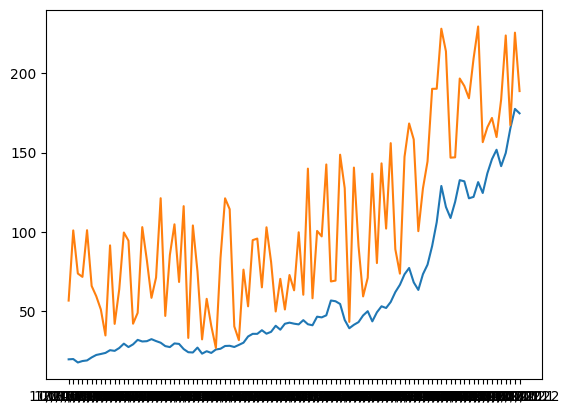

In [30]:
import matplotlib
import matplotlib.pyplot as plt


data = pd.read_csv('./original.csv')
data_new = pd.read_csv('./train.csv')
plt.plot(data['Date'],data['Price'],data_new['Date'],data_new['Price'])
